# 16-825: Learning for 3D Vision Assignment 1

Zichong Yang

## 1 Practicing with Cameras

In [1]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import mcubes
import pytorch3d
import pytorch3d.io
from pytorch3d.vis.plotly_vis import plot_scene
from tqdm.auto import tqdm

import starter.utils
from pytorch3d.io import load_obj

# Test if using GPU
print("Using GPU:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# image size for rendering
image_size = 512

Using GPU: True


In [2]:
# Load the cow mesh
# Reference (provided Tutorial): https://colab.research.google.com/drive/1FLVJSRxT0-d2MNQg4Q7o5UQEWaSQ9u3h?usp=sharing
cow_vertices, cow_face_props, cow_text_props = load_obj("data/cow.obj")
cow_faces = cow_face_props.verts_idx
cow_vertices = cow_vertices.unsqueeze(0)
cow_faces = cow_faces.unsqueeze(0)
cow_verts_uvs = cow_text_props.verts_uvs
cow_faces_uvs = cow_face_props.textures_idx

# Load the cow texture
cow_texture_map = plt.imread("data/cow_texture.png")
cow_textures_uv = pytorch3d.renderer.TexturesUV(
    maps=torch.tensor([cow_texture_map]),
    faces_uvs=cow_faces_uvs.unsqueeze(0),
    verts_uvs=cow_verts_uvs.unsqueeze(0),
).to(device)

# Once provided the vetices, faces and texures, we can create a mesh 
meshes = pytorch3d.structures.Meshes(
    verts=cow_vertices,
    faces=cow_faces,
    textures=cow_textures_uv,
)
meshes = meshes.to(device)  # Move mesh to GPU

# use the renderer wrapper to set up a renderer
renderer = starter.utils.get_mesh_renderer(image_size=image_size, device=device)

/tmp/ipykernel_526916/1354331292.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/torch/csrc/utils/tensor_new.cpp:230.)
  maps=torch.tensor([cow_texture_map]),


### 1.1 360-degree Renders

In [3]:
# set 120 cameras to render images 
num_views = 120

R, T = pytorch3d.renderer.look_at_view_transform(
    dist=3,
    elev=0,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)

many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

images = renderer(meshes.extend(num_views), cameras=many_cameras)
images = (images.cpu().numpy() * 255).astype(np.uint8)
imageio.mimsave('output/q1-1.gif', images, fps=30)

### 1.2 Re-creating the Dolly Zoom (10 points)

Codes for this part are modified in `starter/dolly_zoom.py`

In [16]:
!python -m starter.dolly_zoom

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 70.23it/s]


## 2 Practicing with Meshes

### 2.1 Constructing a Tetrahedron

In [55]:
# Define vertices and faces manually
tetrahedron_vertices = torch.tensor([[1, -0.5, 0], [0, 1, 0], [0, -0.5, 1], [-0.5, -0.5, -0.5]], dtype=torch.float32).unsqueeze(0)
tetrahedron_faces = torch.tensor([[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]).unsqueeze(0)
# Use the TexturesVertex to assign color for each vertex. The size of vertices= the size of color
tetrahedron_textures_rgb = torch.ones_like(tetrahedron_vertices)
tetrahedron_textures_rgb = tetrahedron_textures_rgb * torch.tensor([0.7, 0.7, 1.0])

# Once provided the vetices, faces and texures, we can create a mesh
meshes = pytorch3d.structures.Meshes(
    verts=tetrahedron_vertices,
    faces=tetrahedron_faces,
    textures=pytorch3d.renderer.TexturesVertex(verts_features=tetrahedron_textures_rgb)
).to(device)

# set 120 cameras to render images 
num_views = 120

R, T = pytorch3d.renderer.look_at_view_transform(
    dist=3,
    elev=0,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)

many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

lights = pytorch3d.renderer.PointLights(
    device=device,
    location=[[2.0, 2.0, 2.0]]
)

images = renderer(meshes.extend(num_views), cameras=many_cameras, lights=lights)
images = (images.cpu().numpy() * 255).astype(np.uint8)
imageio.mimsave('output/q2-1.gif', images, fps=30)

### 2.2 Constructing a Cube

In [61]:
# Define vertices and faces manually
cube_vertices = torch.tensor([
    [-1., -1., -1.],
    [-1., -1., 1.],
    [-1., 1., -1.],
    [-1., 1., 1.],
    [1., -1., -1.],
    [1., -1., 1.],
    [1., 1., -1.],
    [1., 1., 1.],
], dtype=torch.float32).unsqueeze(0)
cube_faces = torch.tensor([
    [0, 1, 2],
    [1, 2, 3],
    [0, 1, 4],
    [1, 4, 5],
    [0, 2, 4],
    [2, 4, 6],
    [2, 3, 6],
    [2, 3, 7],
    [1, 3, 5],
    [3, 5, 7],
    [4, 5, 6],
    [5, 6, 7],
]).unsqueeze(0)

# Use the TexturesVertex to assign color for each vertex. The size of vertices= the size of color
cube_textures_rgb = torch.ones_like(cube_vertices)
cube_textures_rgb = cube_textures_rgb * torch.tensor([0.7, 0.7, 1.0])

# Once provided the vetices, faces and texures, we can create a mesh
meshes = pytorch3d.structures.Meshes(
    verts=cube_vertices,
    faces=cube_faces,
    textures=pytorch3d.renderer.TexturesVertex(verts_features=cube_textures_rgb)
).to(device)

# set 120 cameras to render images 
num_views = 120

R, T = pytorch3d.renderer.look_at_view_transform(
    dist=6,
    elev=4,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)

many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

lights = pytorch3d.renderer.PointLights(
    device=device,
    location=[[2.0, 2.0, 2.0]]
)

images = renderer(meshes.extend(num_views), cameras=many_cameras, lights=lights)
images = (images.cpu().numpy() * 255).astype(np.uint8)
imageio.mimsave('output/q2-2.gif', images, fps=30)

## 3 Re-texturing a mesh

In [8]:
# assign the front of the cow a color of color1
color1 = torch.tensor([0, 0, 1])
# assign the back of the cow a color of color2
color2 = torch.tensor([1, 0, 0])

z = cow_vertices[:, :, 2:]
# The front of the cow corresponds to the vertex with the smallest z-coordinate z_min
z_min = z.min()
# The back of the cow corresponds to the vertex with the largest z-coordinate z_max
z_max = z.max()

# The color of each vertex is a linear interpolation between color1 and color2
alpha = (z - z_min) / (z_max - z_min)
color = alpha * color2 + (1 - alpha) * color1
cow_textures = pytorch3d.renderer.TexturesVertex(verts_features=color)

# Once provided the vetices, faces and texures, we can create a mesh 
meshes = pytorch3d.structures.Meshes(
    verts=cow_vertices,
    faces=cow_faces,
    textures=cow_textures,
).to(device)  # Move mesh to GPU

# set 120 cameras to render images 
num_views = 120

R, T = pytorch3d.renderer.look_at_view_transform(
    dist=3,
    elev=4,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)

many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

lights = pytorch3d.renderer.PointLights(
    device=device,
    location=[[2.0, 2.0, 2.0]]
)

images = renderer(meshes.extend(num_views), cameras=many_cameras, lights=lights)
images = (images.cpu().numpy() * 255).astype(np.uint8)
imageio.mimsave('output/q3.gif', images, fps=30)

## 4 Camera Transformations

In [ ]:
from starter.camera_transforms import render_cow
# Setting in the demo
R_relative = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
T_relative = [0, 0, 0]

out = render_cow(
    R_relative=R_relative,
    T_relative=T_relative,
    device=device
)
plt.axis('off')
plt.imshow(out)

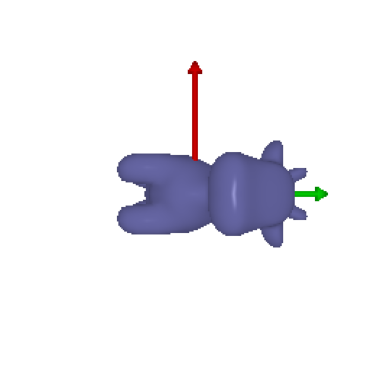

In [14]:
from starter.camera_transforms import render_cow
# Transform 1
R_relative = [
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 1]
]
T_relative = [0, 0, 0]

out = render_cow(
    R_relative=R_relative,
    T_relative=T_relative,
    device=device
)
plt.axis('off')
plt.imshow(out)
plt.imsave('output/q4-1.png', out)

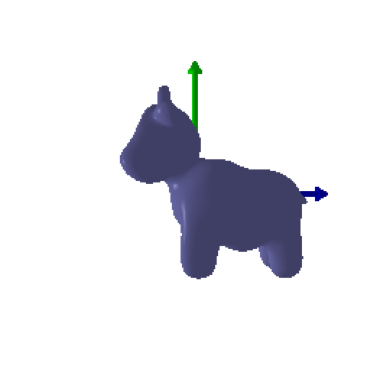

In [17]:
from starter.camera_transforms import render_cow
# Transform 2
R_relative = [
    [0, 0, -1],
    [0, 1, 0],
    [1, 0, 0]
]
T_relative = [3, 0, 3]

out = render_cow(
    R_relative=R_relative,
    T_relative=T_relative,
    device=device
)
plt.axis('off')
plt.imshow(out)
plt.imsave('output/q4-2.png', out)

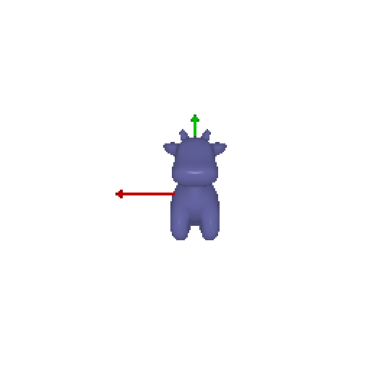

In [19]:
from starter.camera_transforms import render_cow
# Transform 3
R_relative = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
T_relative = [0, 0, 2]

out = render_cow(
    R_relative=R_relative,
    T_relative=T_relative,
    device=device
)
plt.axis('off')
plt.imshow(out)
plt.imsave('output/q4-3.png', out)

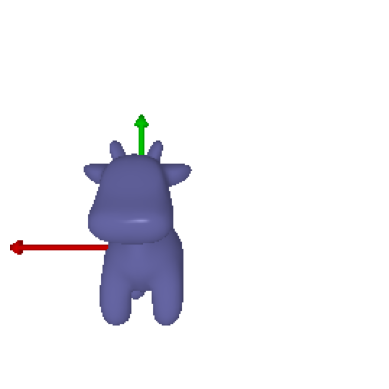

In [20]:
from starter.camera_transforms import render_cow
# Transform 4
R_relative = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
T_relative = [0.5, -0.5, 0]

out = render_cow(
    R_relative=R_relative,
    T_relative=T_relative,
    device=device
)
plt.axis('off')
plt.imshow(out)
plt.imsave('output/q4-4.png', out)

## 5 Rendering Generic 3D Representations

### 5.1 Rendering Point Clouds from RGB-D Images

In [7]:
from starter.render_generic import *
from starter.utils import *

# load the data for 2 images of the same plant
rgbd_data = load_rgbd_data()

rgb1 = rgbd_data['rgb1']
rgb2 = rgbd_data['rgb2']
rgb1 = torch.Tensor(rgb1)
rgb2 = torch.Tensor(rgb2)
mask1 = rgbd_data['mask1']
mask2 = rgbd_data['mask2']
mask1 = torch.Tensor(mask1)
mask2 = torch.Tensor(mask2)
depth1 = rgbd_data['depth1']
depth2 = rgbd_data['depth2']
depth1 = torch.Tensor(depth1)
depth2 = torch.Tensor(depth2)
cameras1 = rgbd_data['cameras1']
cameras2 = rgbd_data['cameras2']

# set up the point cloud renderer
pc_renderer = get_points_renderer(image_size=256, radius=0.01)

In [ ]:
# convert a depth image into a point cloud
# (parameterized as a set of 3D coordinates and corresponding color values)
points1, rgba1 = unproject_depth_image(rgb1, mask1, depth1, cameras1)
pointclouds1 = pytorch3d.structures.Pointclouds(
    points=points1.unsqueeze(0),
    features=rgba1[:, :3].unsqueeze(0)
).to(device)

points2, rgba2 = unproject_depth_image(rgb2, mask2, depth2, cameras2)
pointclouds2 = pytorch3d.structures.Pointclouds(
    points=points2.unsqueeze(0),
    features=rgba2[:, :3].unsqueeze(0)
).to(device)

points_combined = torch.cat([points1, points2], dim=0)
rgba_combined = torch.cat([rgba1, rgba2], dim=0)
pointclouds_combined = pytorch3d.structures.Pointclouds(
    points=points_combined.unsqueeze(0),
    features=rgba_combined[:, :3].unsqueeze(0)
).to(device)

# set 120 cameras to render images 
num_views = 120

R, T = pytorch3d.renderer.look_at_view_transform(
    dist=6,
    elev=0,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)

# The original point cloud is upside down, so we need to flip it
R_relative = torch.tensor([[-1., 0., 0.], [0., -1., 0.], [0., 0., 1.]])
R = torch.stack([R_relative @ r for r in R])
T = torch.stack([R_relative @ t for t in T])

many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

images = pc_renderer(pointclouds1.extend(num_views), cameras=many_cameras)
images = (images.cpu().numpy() * 255).astype(np.uint8)
imageio.mimsave('output/q5-1-1.gif', images, fps=30)

images = pc_renderer(pointclouds2.extend(num_views), cameras=many_cameras)
images = (images.cpu().numpy() * 255).astype(np.uint8)
imageio.mimsave('output/q5-1-2.gif', images, fps=30)

images = pc_renderer(pointclouds_combined.extend(num_views), cameras=many_cameras)
images = (images.cpu().numpy() * 255).astype(np.uint8)
imageio.mimsave('output/q5-1-3.gif', images, fps=30)

### 5.2 Parametric Functions

In [6]:
# Referred from the tutorial
num_samples = 500
r1 = 0.5
r2 = 1.0

phi = torch.linspace(0, 2 * np.pi, num_samples)
theta = torch.linspace(0, 2 * np.pi, num_samples)
Phi, Theta = torch.meshgrid(phi, theta, indexing="ij")

x = (r2 + r1 * torch.cos(Theta)) * torch.cos(Phi)
y = (r2 + r1 * torch.cos(Theta)) * torch.sin(Phi)
z = r1 * torch.sin(Theta)

points = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
color = (points - points.min()) / (points.max() - points.min())

sphere_point_cloud = pytorch3d.structures.Pointclouds(
    points=[points], features=[color],
).to(device)

pc_renderer = starter.utils.get_points_renderer(radius=0.01)

# set 120 cameras to render images 
num_views = 120

R, T = pytorch3d.renderer.look_at_view_transform(
    dist=6,
    elev=0,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)

many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

images = pc_renderer(sphere_point_cloud.extend(num_views), cameras=many_cameras)
images = (images.cpu().numpy() * 255).astype(np.uint8)
imageio.mimsave('output/q5-2.gif', images, fps=30)

### 5.3 Implicit Surfaces

In [13]:
voxel_size=64
r1 = 0.5
r2 = 1.0
min_value = -1.6
max_value = 1.6

X, Y, Z = torch.meshgrid([torch.linspace(min_value, max_value, voxel_size)] * 3)
voxels = (torch.sqrt(X ** 2 + Y ** 2) - r2) **2 + Z ** 2 - r1 ** 2

vertices, faces = mcubes.marching_cubes(mcubes.smooth(voxels), isovalue=0)
vertices = torch.tensor(vertices).float()
faces = torch.tensor(faces.astype(int))
# Vertex coordinates are indexed by array position, so we need to renormalize the coordinate system.
vertices = (vertices / voxel_size) * (max_value - min_value) + min_value
textures = (vertices - vertices.min()) / (vertices.max() - vertices.min())
textures = pytorch3d.renderer.TexturesVertex(textures.unsqueeze(0))

mesh = pytorch3d.structures.Meshes([vertices], [faces], textures=textures).to(
    device
)

num_views = 120
R, T = pytorch3d.renderer.look_at_view_transform(
    dist=6,
    elev=0,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)
many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

# use the renderer wrapper to set up a renderer
renderer = starter.utils.get_mesh_renderer(image_size=image_size, device=device)

images = renderer(mesh.extend(num_views), cameras=many_cameras)
images = (images.cpu().numpy() * 255).astype(np.uint8)
imageio.mimsave('output/q5-3.gif', images, fps=30)

## 6 Do Something Fun

In [11]:
num_views = 120

renderer = starter.utils.get_mesh_renderer(image_size=image_size, device=device)

R, T = pytorch3d.renderer.look_at_view_transform(
    dist=3,
    elev=0,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)

many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

images = [] 

for i in range(num_views):
    # Define vertices and faces manually
    tetrahedron_vertices = torch.tensor([[1, -0.5, 0], [0, 1+3*i/num_views, 0], [0, -0.5, 1], [-0.5, -0.5, -0.5]], dtype=torch.float32).unsqueeze(0)
    tetrahedron_faces = torch.tensor([[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]).unsqueeze(0)
    # Use the TexturesVertex to assign color for each vertex. The size of vertices= the size of color
    # tetrahedron_textures_rgb = torch.ones_like(tetrahedron_vertices)
    # tetrahedron_textures_rgb = tetrahedron_textures_rgb * torch.tensor([0.7, 0.7, 1.0])
    textures = (tetrahedron_vertices - tetrahedron_vertices.min()) / (tetrahedron_vertices.max() - tetrahedron_vertices.min())
    textures = pytorch3d.renderer.TexturesVertex(textures)

    # Once provided the vetices, faces and texures, we can create a mesh
    meshes = pytorch3d.structures.Meshes(
        verts=tetrahedron_vertices,
        faces=tetrahedron_faces,
        textures=textures
    ).to(device)

    image = renderer(meshes, cameras=many_cameras[i])
    image = (image.cpu().numpy() * 255).astype(np.uint8)[0,:,:,:3]
    images.append(image)
imageio.mimsave('output/q6.gif', np.array(images), fps=30)

## 7 Sampling Points on Meshes

In [1]:
num_samples_list = [100, 500, 1000, 10000]

def get_face_area(vertices, face):
    """
    Args:
        vertices: (V, 3) tensor of vertex positions
        faces: (3) tensor of face indices
    Returns:
        area: tensor of face area
    """
    v1, v2, v3 = vertices[face]
    a = torch.norm(v2 - v1)
    b = torch.norm(v3 - v2)
    c = torch.norm(v1 - v3)
    s = (a + b + c) / 2
    area = torch.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

def get_face_areas(vertices, faces):
    """
    Args:
        vertices: (V, 3) tensor of vertex positions
        faces: (F, 3) tensor of face indices
    Returns:
        areas: (F) tensor of face areas
    """
    areas = torch.zeros(faces.shape[0]).to(device)
    for i, face in enumerate(faces):
        areas[i] = get_face_area(vertices, face)
    return areas

def mesh_to_pointcloud(vertices, faces, num_samples, device):
    """
    Args:
        vertices: (V, 3) tensor of vertex positions
        faces: (F, 3) tensor of face indices
        num_samples: number of points to sample
    Returns:
        points: (N, 3) tensor of sampled points
    """
    points = torch.zeros(num_samples, 3).to(device)
    areas = get_face_areas(vertices, faces)
    areas = areas / areas.sum()
    faces_idx_sampled = np.random.choice(faces.shape[0], num_samples, p=areas.cpu().numpy())
    for i, idx in enumerate(faces_idx_sampled):
        v1, v2, v3 = vertices[faces[idx]]
        r1 = torch.rand(1)
        r2 = torch.rand(1)
        point = (1 - torch.sqrt(r1)) * v1 + (torch.sqrt(r1) * (1 - r2)) * v2 + (torch.sqrt(r1) * r2) * v3
        points[i] = point
    return points

def render_pointcloud(vertices, faces, num_samples):
    num_views = 120
    R, T = pytorch3d.renderer.look_at_view_transform(
        dist=6,
        elev=0,
        azim=np.linspace(-180, 180, num_views, endpoint=False),
    )
    many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
        R=R,
        T=T,
        device=device
    )
    points = mesh_to_pointcloud(vertices, faces, num_samples, device)
    color = (points - points.min()) / (points.max() - points.min())
    point_cloud = pytorch3d.structures.Pointclouds(
        points=[points], features=[color],
    ).to(device)
    pc_renderer = starter.utils.get_points_renderer(radius=0.01)
    images = pc_renderer(point_cloud.extend(num_views), cameras=many_cameras)
    images = (images.cpu().numpy() * 255).astype(np.uint8)

    return images

def render_mesh(vertices, faces):
    num_views = 120
    R, T = pytorch3d.renderer.look_at_view_transform(
        dist=6,
        elev=0,
        azim=np.linspace(-180, 180, num_views, endpoint=False),
    )
    many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
        R=R,
        T=T,
        device=device
    )
    textures = (vertices - vertices.min()) / (vertices.max() - vertices.min())
    textures = pytorch3d.renderer.TexturesVertex(textures.unsqueeze(0))
    mesh = pytorch3d.structures.Meshes([vertices], [faces], textures=textures).to(device)
    renderer = starter.utils.get_mesh_renderer(image_size=image_size, device=device)
    images = renderer(mesh.extend(num_views), cameras=many_cameras)
    images = (images.cpu().numpy() * 255).astype(np.uint8)
    return images[:, :, :, :3]

In [ ]:
cow_vertices, cow_face_props, cow_text_props = pytorch3d.io.load_obj("data/cow.obj")
cow_faces = cow_face_props.verts_idx

cow_output = []
cow_output.append(render_mesh(cow_vertices, cow_faces))
for num_samples in num_samples_list:
    cow_output.append(render_pointcloud(cow_vertices, cow_faces, num_samples))
cow_output = np.concatenate(cow_output, axis=2)
imageio.mimsave('output/q7-1.gif', cow_output, fps=30)

In [ ]:
joint_mesh_vertices, joint_mesh_face_props, joint_mesh_text_props = pytorch3d.io.load_obj("data/joint_mesh.obj")
joint_mesh_faces = joint_mesh_face_props.verts_idx

joint_mesh_output = []
joint_mesh_output.append(render_mesh(joint_mesh_vertices, joint_mesh_faces))
for num_samples in num_samples_list:
    joint_mesh_output.append(render_pointcloud(joint_mesh_vertices, joint_mesh_faces, num_samples))
joint_mesh_output = np.concatenate(joint_mesh_output, axis=2)
imageio.mimsave('output/q7-2.gif', joint_mesh_output, fps=30)